***1. Mount Drive & Set Paths***


---


Mount Google Drive

Define SITES_DIR and GLOBAL_RADIATION_PATH

Auto-detect DEMs

In [ ]:
# 1. Mount Drive & Set Paths

from google.colab import drive
drive.mount('/content/drive')

import os
import glob

# Folders
SITES_DIR = "/content/drive/MyDrive/MARS/Sites_TIF_4"
GLOBAL_RADIATION_PATH = "/content/drive/MyDrive/MARS/PIA03480.tif"

# List all DEMs in the Sites_TIF_4 folder
site_tifs = sorted(glob.glob(os.path.join(SITES_DIR, "*.tif")))

print("Detected DEM files:")
for i, f in enumerate(site_tifs):
    print(f"{i}: {os.path.basename(f)}")

print("\nRadiation map exists:", os.path.exists(GLOBAL_RADIATION_PATH))

# Safety checks
if len(site_tifs) == 0:
    raise FileNotFoundError("No .tif files found in SITES_DIR. Check the folder or filenames.")
if not os.path.exists(GLOBAL_RADIATION_PATH):
    raise FileNotFoundError("PIA03480.tif not found in /MyDrive/MARS.")


Mounted at /content/drive
Detected DEM files:
0: ESP_046252_1975_dem_1m_5km.tif
1: PSP_001432_2015_dem_1m_5km.tif
2: PSP_003542_2035_dem_1m_5km.tif
3: PSP_005533_1975_dem_1m_5km.tif

Radiation map exists: True


**2. Select Site & Define Coordinates**


---


Site selection (SITE_INDEX)

Auto-load DEM path

Insert lat/lon for this site

Build ProjectConfig dataclass

In [ ]:
# 2. Select Site & Define Coordinates

from dataclasses import dataclass

# Choose which site to work on
SITE_INDEX = 0  # change to 1, 2, or 3 to switch site

DEM_PATH = site_tifs[SITE_INDEX]
print("Using DEM:", DEM_PATH)

# Coordinates for the 4 DTMs (center latitude/longitude, degrees East)
# Values taken from HiRISE pages for each product.
SITE_COORDS = [
    (17.25,   233.3),   # 0: ESP_046252_1975  (Fissure East of Olympus Mons) :contentReference[oaicite:1]{index=1}
    (21.6,    222.3),   # 1: PSP_001432_2015 (Layers in a scarp on Olympus Mons) :contentReference[oaicite:2]{index=2}
    (23.329,  223.743), # 2: PSP_003542_2035 (Dark slope streak N of Olympus Mons) :contentReference[oaicite:3]{index=3}
    (17.28,   226.6),   # 3: PSP_005533_1975 (Fresh crater on Olympus Mons) :contentReference[oaicite:4]{index=4}
]

SITE_LAT, SITE_LON = SITE_COORDS[SITE_INDEX]
print(f"Site {SITE_INDEX} lat/lon:", SITE_LAT, SITE_LON)

@dataclass
class ProjectConfig:
    DEM_PATH: str = DEM_PATH
    GLOBAL_RADIATION_PATH: str = GLOBAL_RADIATION_PATH
    SITE_LAT: float = SITE_LAT
    SITE_LON: float = SITE_LON

    TILE_SIZE: int = 256
    TILE_STRIDE: int = 128

    # Growth / scoring weights (can be tuned later)
    W_SLOPE: float = 1.0
    W_ROUGHNESS: float = 0.5
    W_RADIATION: float = 2.0
    W_DIST_POI: float = -1.0

cfg = ProjectConfig()
cfg


Using DEM: /content/drive/MyDrive/MARS/Sites_TIF_4/ESP_046252_1975_dem_1m_5km.tif
Site 0 lat/lon: 17.25 233.3


ProjectConfig(DEM_PATH='/content/drive/MyDrive/MARS/Sites_TIF_4/ESP_046252_1975_dem_1m_5km.tif', GLOBAL_RADIATION_PATH='/content/drive/MyDrive/MARS/PIA03480.tif', SITE_LAT=17.25, SITE_LON=233.3, TILE_SIZE=256, TILE_STRIDE=128, W_SLOPE=1.0, W_ROUGHNESS=0.5, W_RADIATION=2.0, W_DIST_POI=-1.0)

**3.Imports & Device Setup**


---


Torch, rasterio, numpy, skimage, networkx

CUDA check

In [ ]:
# 3. Install Dependencies (rasterio, geopandas, shapely, networkx if needed)

!pip install rasterio shapely fiona pyproj --quiet
!pip install geopandas --quiet
!pip install scikit-image --quiet
!pip install tqdm --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 116.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 104.3 MB/s eta 0:00:00


In [ ]:
# 4. Imports & Device Setup

import numpy as np
import matplotlib.pyplot as plt

import rasterio
from rasterio.warp import reproject, Resampling

from skimage.filters import sobel
import networkx as nx
from tqdm.auto import tqdm

import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


**4.Utility Functions**


---


load_raster

normalize_channel

align_raster_to_dem

compute_slope

compute_roughness

load_global_radiation_image

sample_global_radiation

POI distance fields

In [ ]:
# 4. Utility Functions

def load_raster(path: str):
    """Load a single-band GeoTIFF and return (array, transform, profile)."""
    src = rasterio.open(path)
    arr = src.read(1).astype(np.float32)
    return arr, src.transform, src.profile

def align_raster_to_dem(src_path: str, dem_profile, dem_transform):
    """
    Warp + resample any raster to match the DEM grid.
    (We may not need this immediately for PIA03480, but it's useful for later.)
    """
    H, W = dem_profile["height"], dem_profile["width"]
    dst = np.full((H, W), np.nan, dtype=np.float32)

    with rasterio.open(src_path) as src:
        reproject(
            rasterio.band(src, 1),
            dst,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=dem_transform,
            dst_crs=dem_profile["crs"],
            resampling=Resampling.bilinear,
        )
    return dst

def normalize_channel(arr, eps=1e-6):
    """Normalize an array to [0,1], ignoring NaNs."""
    mask = np.isfinite(arr)
    if not np.any(mask):
        return np.zeros_like(arr, dtype=np.float32)
    vmin = np.nanpercentile(arr[mask], 1)
    vmax = np.nanpercentile(arr[mask], 99)
    out = (arr - vmin) / (vmax - vmin + eps)
    return np.clip(out, 0, 1).astype(np.float32)

def compute_slope(dem, transform):
    """
    Approximate slope in degrees from DEM using central differences.
    Assumes north-up, equirectangular DEM.
    """
    dx = transform.a
    dy = -transform.e  # usually negative
    gy, gx = np.gradient(dem, dy, dx)
    slope_rad = np.arctan(np.sqrt(gx**2 + gy**2))
    slope_deg = np.degrees(slope_rad).astype(np.float32)
    return slope_deg

def compute_roughness(dem, window_size=5):
    """
    Local elevation standard deviation as a roughness proxy.
    Simple but effective for our scale.
    """
    pad = window_size // 2
    padded = np.pad(dem, pad, mode="edge")
    h, w = dem.shape
    out = np.zeros_like(dem, dtype=np.float32)
    for i in range(h):
        for j in range(w):
            window = padded[i:i+window_size, j:j+window_size]
            out[i, j] = window.std()
    return out

import matplotlib.image as mpimg

def load_global_radiation_image(path: str):
    """
    Load PIA03480 as a grayscale image.
    No CRS metadata, treat as lat/lon image:
    - columns: 0..W-1 ↔ longitude 0..360°E
    - rows:    0..H-1 ↔ latitude +90..-90°
    """
    img = mpimg.imread(path)
    if img.ndim == 3:
        img = img[..., 0]
    return img.astype(np.float32)

def sample_global_radiation(lat_deg: float, lon_deg: float, img: np.ndarray):
    """
    Sample the global radiation image at a given lat/lon (planetocentric, °E).
    """
    H, W = img.shape
    lon = lon_deg % 360.0
    col = int((lon / 360.0) * W)
    row = int(((90.0 - lat_deg) / 180.0) * H)
    row = np.clip(row, 0, H - 1)
    col = np.clip(col, 0, W - 1)
    return img[row, col]

def create_poi_distance_fields(shape, transform, poi_xy):
    """
    Compute distance and direction fields to a given POI in map coordinates.
    Returns:
      dist_norm, dir_x, dir_y
    """
    h, w = shape
    xs, ys = np.meshgrid(np.arange(w), np.arange(h))
    x_map = transform.c + xs * transform.a
    y_map = transform.f + ys * transform.e

    dx = poi_xy[0] - x_map
    dy = poi_xy[1] - y_map

    dist = np.sqrt(dx**2 + dy**2).astype(np.float32)
    dist_norm = normalize_channel(dist)

    mag = dist + 1e-6
    dir_x = dx / mag
    dir_y = dy / mag

    return dist_norm, dir_x.astype(np.float32), dir_y.astype(np.float32)


In [ ]:
# Fast roughness using SciPy's uniform_filter (replaces previous compute_roughness)

!pip install scipy --quiet
from scipy.ndimage import uniform_filter

def compute_roughness(dem, window_size=5):
    """
    Local elevation standard deviation as roughness, computed efficiently.
    Uses a sliding window with uniform_filter.
    """
    dem = dem.astype(np.float32)
    # Handle NaNs: replace with local mean later by masking
    nan_mask = ~np.isfinite(dem)
    # temporary: set NaNs to 0 (they'll be ignored in normalization anyway)
    tmp = dem.copy()
    tmp[nan_mask] = 0.0

    mean = uniform_filter(tmp, size=window_size)
    mean_sq = uniform_filter(tmp**2, size=window_size)
    var = mean_sq - mean**2
    var[var < 0] = 0.0

    rough = np.sqrt(var).astype(np.float32)
    return rough


**5.Load DEM & Compute Terrain Fields**


---


Load DEM

Compute slope, roughness

Normalize DEM-based layers

DEM shape: (5001, 5001)
DEM CRS: PROJCS["EQUIRECTANGULAR MARS",GEOGCS["GCS_MARS",DATUM["D_MARS",SPHEROID["MARS_localRadius",3394839.8133163,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",15],PARAMETER["central_meridian",233.34],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Pixel size: 1.0 -1.0
Nodata value: -3.4028226550889045e+38


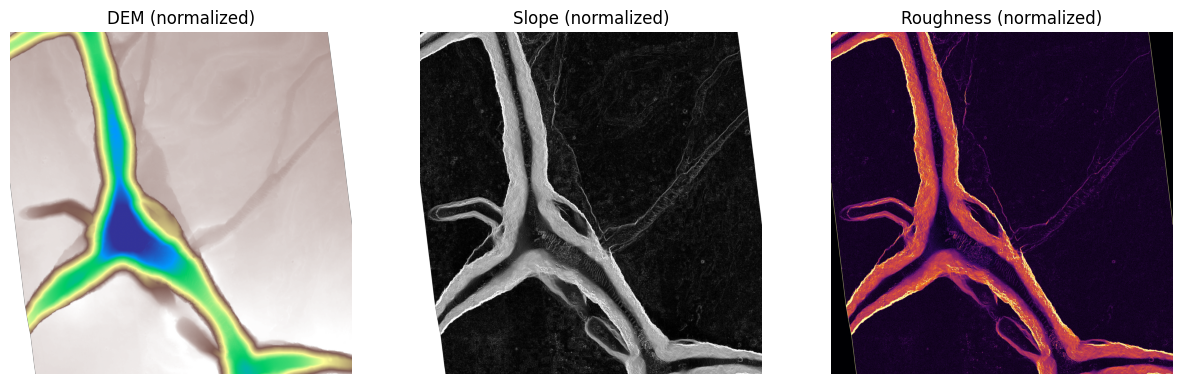

In [ ]:
# 5. Load DEM & Compute Terrain Fields

dem, dem_transform, dem_profile = load_raster(cfg.DEM_PATH)

print("DEM shape:", dem.shape)
print("DEM CRS:", dem_profile.get("crs", "None"))
print("Pixel size:", dem_transform.a, dem_transform.e)
print("Nodata value:", dem_profile.get("nodata"))

# Replace nodata with NaN so gradients/roughness don't explode
nodata = dem_profile.get("nodata")
if nodata is not None:
    dem = np.where(dem == nodata, np.nan, dem)

# Compute slope (will propagate NaNs)
slope = compute_slope(dem, dem_transform)

# Compute roughness with the fast function
roughness = compute_roughness(dem, window_size=5)

# Normalize channels
dem_n       = normalize_channel(dem)
slope_n     = normalize_channel(slope)
rough_n     = normalize_channel(roughness)

# Quick visual check
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(dem_n, cmap="terrain")
axs[0].set_title("DEM (normalized)")
axs[0].axis("off")

axs[1].imshow(slope_n, cmap="gray")
axs[1].set_title("Slope (normalized)")
axs[1].axis("off")

axs[2].imshow(rough_n, cmap="inferno")
axs[2].set_title("Roughness (normalized)")
axs[2].axis("off")

plt.show()


**6.Load Radiation & Build Final Radiation Layer**
Load global radiation PIA03480


---


Compute global baseline

Compute local DEM anomaly

Build radiation_raw

Normalize to radiation_n

Global radiation map loaded: (2400, 3000)
Baseline radiation at site (image units): 49.0000


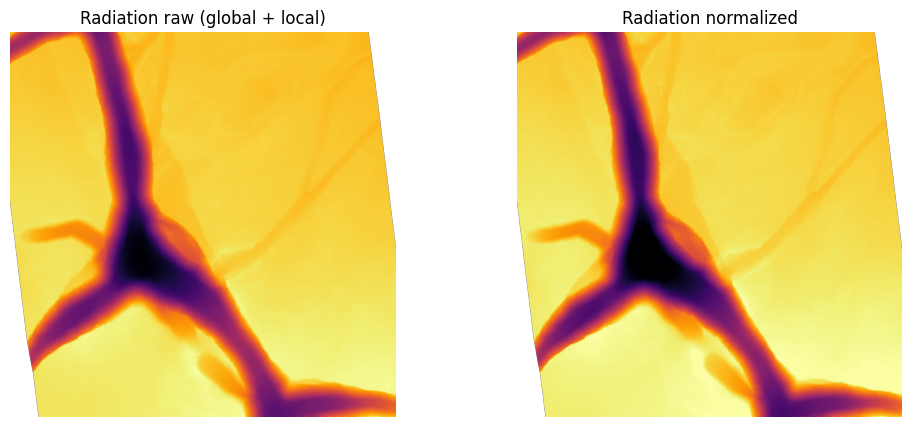

In [ ]:
# 6. Load Radiation & Build Final Radiation Layer

# Load global radiation map (PIA03480)
rad_global_img = load_global_radiation_image(cfg.GLOBAL_RADIATION_PATH)

print("Global radiation map loaded:", rad_global_img.shape)

# Sample global baseline radiation value based on site coordinates
base_rad_value = sample_global_radiation(cfg.SITE_LAT, cfg.SITE_LON, rad_global_img)
print(f"Baseline radiation at site (image units): {base_rad_value:.4f}")

# --- LOCAL VARIATION FROM DEM ---
# Use DEM anomaly relative to mean elevation
dem_mean = np.nanmean(dem)
dem_anom = dem - dem_mean

# Scaling factor for local variation (tunable)
k = 1.0
radiation_raw = base_rad_value + k * dem_anom

# Normalize the final radiation layer
radiation_n = normalize_channel(radiation_raw)

# Visual check
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(radiation_raw, cmap="inferno")
axs[0].set_title("Radiation raw (global + local)")
axs[0].axis("off")

axs[1].imshow(radiation_n, cmap="inferno")
axs[1].set_title("Radiation normalized")
axs[1].axis("off")

plt.show()


**7.Generate POI Distance Fields**


---


Compute poi_dist, poi_dx, poi_dy

POI is mid-DEM or user-defined

POI pixel indices (row, col): 2500 2500
POI map coordinates (x, y): -167.0 1022007.0


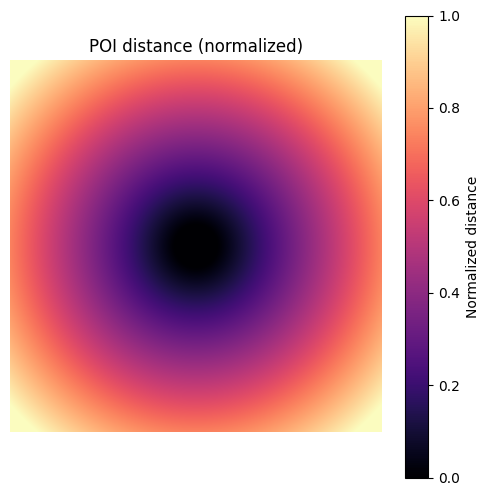

In [ ]:
# 7. Generate POI Distance Fields

# For now, choose the DEM centre as the POI (seed position).
# Later we can replace this with a hand-chosen coordinate or the best radiation-safe spot.

h, w = dem.shape
center_row, center_col = h // 2, w // 2

# Convert pixel indices to map coordinates using the affine transform
poi_x, poi_y = dem_transform * (center_col, center_row)

print("POI pixel indices (row, col):", center_row, center_col)
print("POI map coordinates (x, y):", poi_x, poi_y)

# Compute distance and direction fields to this POI
poi_dist, poi_dir_x, poi_dir_y = create_poi_distance_fields(
    dem.shape,
    dem_transform,
    (poi_x, poi_y),
)

# Quick visual check of distance-to-POI field
plt.figure(figsize=(6, 6))
plt.imshow(poi_dist, cmap="magma")
plt.title("POI distance (normalized)")
plt.axis("off")
plt.colorbar(label="Normalized distance")
plt.show()


**8.Voronoi & Shortest-Walk Integration**


---


Insert your Voronoi tessellation

Insert shortest-walk algorithm

Build fields for ML (cost-distance map, region ID, etc.)

Chosen seed (y, x): 2552 1660
Voronoi seed at pixel: (np.int64(1660), np.int64(2552))
Total Voronoi sites: (1804, 2)


/tmp/ipython-input-3106128929.py:105: RuntimeWarning: Mean of empty slice
  mean_elev[i] = np.nanmean(elevation[m])


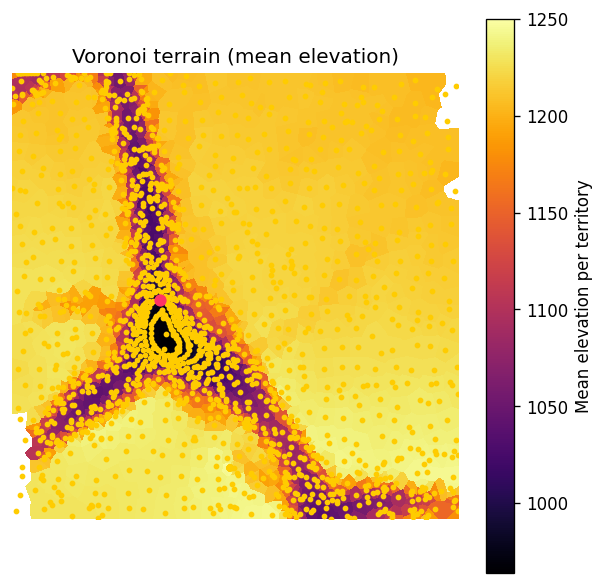

Start site (seed): 1803 elev = 976.8025
Goal site (valley): 358 elev = 964.00574
Path length (sites): 9
Voronoi labels shape: (5001, 5001)
Shortest-walk field shape: (5001, 5001)


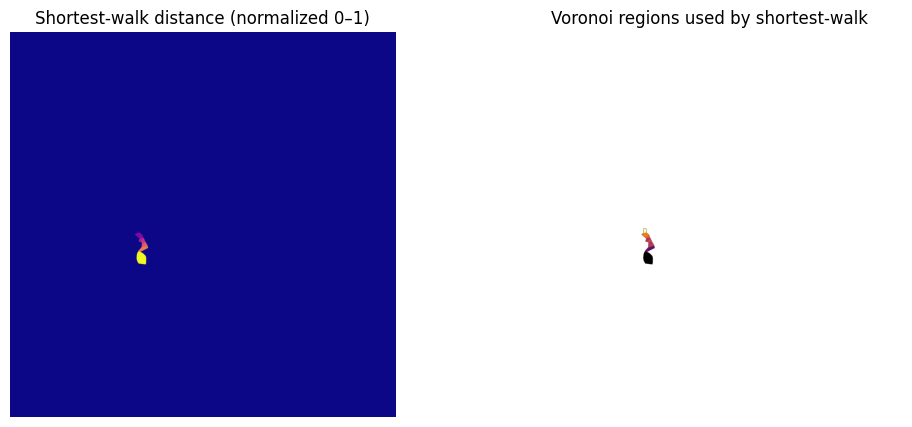

In [ ]:
# 8. Voronoi & Shortest-Walk Fields (Integrated from voronoi template)

from scipy.spatial import Voronoi, cKDTree
import heapq

def generate_hybrid_sites(elevation,
                          seed_xy,
                          grid_spacing=200,
                          contour_interval=10.0,
                          contour_points_per_level=40):
    """
    Hybrid sampling of the DEM to generate Voronoi sites:
      - jittered coarse grid over the DEM for coverage
      - extra points along contour lines for terrain detail
    elevation: 2D array
    seed_xy:   (seed_x, seed_y) in pixel coordinates
    """
    h, w = elevation.shape
    seed_x, seed_y = seed_xy
    rng = np.random.default_rng(0)

    # 1) Jittered background grid
    xs = np.arange(grid_spacing/2, w, grid_spacing)
    ys = np.arange(grid_spacing/2, h, grid_spacing)
    gx, gy = np.meshgrid(xs, ys)
    grid_pts = np.column_stack([gx.ravel(), gy.ravel()])

    jitter = rng.normal(scale=grid_spacing * 0.2, size=grid_pts.shape)
    grid_pts = grid_pts + jitter

    mask = (
        (grid_pts[:, 0] >= 0) & (grid_pts[:, 0] < w) &
        (grid_pts[:, 1] >= 0) & (grid_pts[:, 1] < h)
    )
    sites = [p.tolist() for p in grid_pts[mask]]

    # 2) Contour-based sites
    finite = elevation[np.isfinite(elevation)]
    zmin, zmax = float(finite.min()), float(finite.max())
    start = np.floor(zmin / contour_interval) * contour_interval
    end   = np.ceil(zmax  / contour_interval) * contour_interval
    levels = np.arange(start, end + contour_interval, contour_interval)

    fig, ax = plt.subplots()
    cs = ax.contour(elevation, levels=levels)
    plt.close(fig)  # we don't need to show this

    for seg_list in cs.allsegs:
        if not seg_list:
            continue
        verts = np.vstack(seg_list)
        n = verts.shape[0]
        if n == 0:
            continue
        step = max(1, n // contour_points_per_level)
        sampled = verts[::step]
        for x, y in sampled:
            if 0 <= x < w and 0 <= y < h:
                sites.append([x, y])

    sites = np.array(sites, dtype=float)

    # 3) Ensure seed is included
    d = np.hypot(sites[:, 0] - seed_x, sites[:, 1] - seed_y)
    if np.min(d) > 1.5:
        sites = np.vstack([sites, [seed_x, seed_y]])

    return sites


def make_voronoi_terrain(elevation, seed_x, seed_y):
    """
    Build Voronoi tessellation over DEM and return:
      points       : [N, 2] site coordinates
      labels       : [H, W] Voronoi region index for each pixel
      voronoi_elev : [H, W] mean elevation per territory at each pixel
      mean_elev    : [N]    mean elevation per site
    """
    h, w = elevation.shape

    # 1) Generate sites
    points = generate_hybrid_sites(
        elevation,
        seed_xy=(seed_x, seed_y),
        grid_spacing=200,
        contour_interval=10.0,
        contour_points_per_level=40,
    )
    print("Total Voronoi sites:", points.shape)

    # 2) Assign each pixel to nearest site (KD-tree)
    tree = cKDTree(points)
    yy, xx = np.indices((h, w))
    coords = np.column_stack([xx.ravel(), yy.ravel()])
    _, idx = tree.query(coords, k=1)
    labels = idx.reshape(h, w)

    # 3) Mean elevation per territory
    n_sites = points.shape[0]
    counts = np.bincount(labels.ravel(), minlength=n_sites)
    mean_elev = np.full(n_sites, np.nan, dtype=np.float32)
    for i in range(n_sites):
        if counts[i] > 0:
            m = (labels == i)
            mean_elev[i] = np.nanmean(elevation[m])

    voronoi_elev = mean_elev[labels]

    # Debug plot
    fig, ax = plt.subplots(figsize=(6, 6), dpi=120)
    im = ax.imshow(voronoi_elev, cmap="inferno", interpolation="nearest")
    ax.scatter(points[:, 0], points[:, 1], s=6, color="#ffcc00")
    ax.scatter([seed_x], [seed_y], s=40, color="#ff3366")
    ax.set_xticks([]); ax.set_yticks([])
    for s in ax.spines.values():
        s.set_visible(False)
    plt.colorbar(im, ax=ax, label="Mean elevation per territory")
    plt.title("Voronoi terrain (mean elevation)")
    plt.show()

    return points, labels, voronoi_elev, mean_elev


def voronoi_shortest_walk(points, labels, mean_elev, seed_x, seed_y, beta=0.002):
    """
    Compute shortest path on the Voronoi adjacency graph.
    Returns:
      path_sites     : list of site indices along the path
      shortest_field : [H, W] float32, normalized 0..1 distance along path
      path_mask      : [H, W] bool, True where Voronoi region is in path
    """
    h, w = labels.shape
    n_sites = points.shape[0]

    # Build Voronoi adjacency graph
    vor = Voronoi(points)
    neighbors = [[] for _ in range(n_sites)]
    for i, j in vor.ridge_points:
        neighbors[i].append(j)
        neighbors[j].append(i)

    # Find start site (closest to seed pixel)
    seed_site = np.argmin(np.hypot(points[:, 0] - seed_x,
                                   points[:, 1] - seed_y))

    # Goal site: valid site (non-NaN mean_elev) with lowest elevation
    valid_idx = np.where(~np.isnan(mean_elev))[0]
    goal_site = valid_idx[np.argmin(mean_elev[valid_idx])]

    print("Start site (seed):", seed_site, "elev =", mean_elev[seed_site])
    print("Goal site (valley):", goal_site, "elev =", mean_elev[goal_site])

    # Dijkstra shortest path
    dist = np.full(n_sites, np.inf, dtype=np.float64)
    prev = np.full(n_sites, -1, dtype=int)
    dist[seed_site] = 0.0
    heap = [(0.0, seed_site)]

    while heap:
        d, u = heapq.heappop(heap)
        if d > dist[u]:
            continue
        if u == goal_site:
            break
        for v in neighbors[u]:
            if np.isnan(mean_elev[u]) or np.isnan(mean_elev[v]):
                continue
            spatial = np.linalg.norm(points[u] - points[v])
            elev_penalty = abs(mean_elev[u] - mean_elev[v])
            w_uv = spatial * (1.0 + beta * elev_penalty)
            nd = d + w_uv
            if nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(heap, (nd, v))

    # Reconstruct path
    path_sites = []
    v = goal_site
    if prev[v] == -1 and v != seed_site:
        print("No valid path found.")
    else:
        while v != -1:
            path_sites.append(v)
            v = prev[v]
        path_sites = path_sites[::-1]

    print("Path length (sites):", len(path_sites))

    # Build per-pixel path mask
    if len(path_sites) == 0:
        shortest_field = np.zeros_like(labels, dtype=np.float32)
        path_mask = np.zeros_like(labels, dtype=bool)
        return path_sites, shortest_field, path_mask

    path_mask = np.isin(labels, path_sites)

    # Build normalized distance along path
    pts = points[path_sites]
    seg_len = np.hypot(np.diff(pts[:, 0]), np.diff(pts[:, 1]))
    cum_len = np.concatenate([[0.0], np.cumsum(seg_len)])
    if cum_len[-1] == 0:
        norm_len = cum_len
    else:
        norm_len = cum_len / cum_len[-1]

    site_to_dist = {s: d for s, d in zip(path_sites, norm_len)}

    shortest_field = np.zeros_like(labels, dtype=np.float32)
    for s, d in site_to_dist.items():
        shortest_field[labels == s] = d

    return path_sites, shortest_field, path_mask


# ---------- Seed selection (NO shortest_walk here) ----------

def choose_seed_from_cost(slope_n, radiation_n, w_s=0.4, w_r=0.6):
    """
    Choose a seed pixel by minimizing terrain+environment cost:
      cost = w_s*slope + w_r*radiation
    """
    cost = w_s * slope_n + w_r * radiation_n
    idx = np.nanargmin(cost)
    return np.unravel_index(idx, cost.shape)


seed_y, seed_x = choose_seed_from_cost(slope_n, radiation_n)
print("Chosen seed (y, x):", seed_y, seed_x)
print("Voronoi seed at pixel:", (seed_x, seed_y))

# ---------- Build Voronoi + shortest walk ----------

points, voronoi_labels, voronoi_elev, mean_elev = make_voronoi_terrain(
    dem,
    int(seed_x),
    int(seed_y),
)

path_sites, shortest_walk, path_mask = voronoi_shortest_walk(
    points,
    voronoi_labels,
    mean_elev,
    int(seed_x),
    int(seed_y),
    beta=0.002,
)

print("Voronoi labels shape:", voronoi_labels.shape)
print("Shortest-walk field shape:", shortest_walk.shape)

# Quick visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(shortest_walk, cmap="plasma")
axs[0].set_title("Shortest-walk distance (normalized 0–1)")
axs[0].axis("off")

axs[1].imshow(np.where(path_mask, voronoi_elev, np.nan), cmap="inferno")
axs[1].set_title("Voronoi regions used by shortest-walk")
axs[1].axis("off")

plt.show()


**9.Physarum Growth Parameters & Scalar Fields**


---
Define all growth parameters in one place (weights, diffusion rates, evaporation, branching, number of agents).

Build the combined scalar “attractiveness” field:

slope, roughness, radiation, shortest-walk, POI, etc.




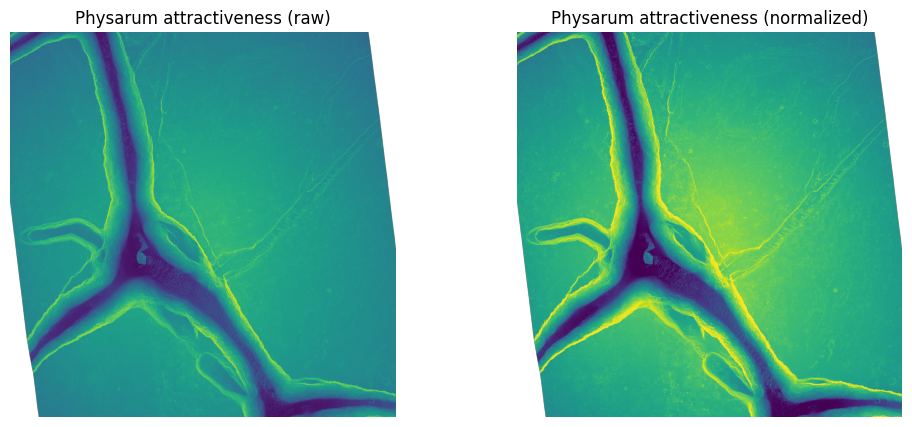

Attractiveness field shape: (5001, 5001)


In [ ]:
# 9. Physarum Growth Parameters & Scalar Fields

# === Growth weights (initial tuning) ===
# You can tune these later to guide colony behavior.
w_slope      = cfg.W_SLOPE        # terrain difficulty
w_rough      = cfg.W_ROUGHNESS    # micro-obstacles
w_radiation  = cfg.W_RADIATION    # protection incentive
w_poi        = cfg.W_DIST_POI     # move toward POI
w_shortwalk  = 1.0                # follow shortest-walk valleys
w_voronoi    = 0.3                # low-elevation territories preferred

# Normalize Voronoi elevation field
voronoi_elev_n = normalize_channel(voronoi_elev)

# === Build the scalar attractiveness field ===
# Lower A(x,y) = more attractive to Physarum growth
attractiveness = (
    w_slope     * slope_n +
    w_rough     * rough_n +
    w_radiation * radiation_n +
    w_poi       * poi_dist +
    w_shortwalk * shortest_walk +
    w_voronoi   * voronoi_elev_n
).astype(np.float32)

# Normalize for stability
attractiveness_n = normalize_channel(attractiveness)

# === Visualization ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(attractiveness, cmap="viridis")
axs[0].set_title("Physarum attractiveness (raw)")
axs[0].axis("off")

axs[1].imshow(attractiveness_n, cmap="viridis")
axs[1].set_title("Physarum attractiveness (normalized)")
axs[1].axis("off")

plt.show()

print("Attractiveness field shape:", attractiveness_n.shape)


**10.Physarum Agent Simulation → Teacher Masks**


---


Implement the agent-based Physarum-like evolution on that scalar field.

Output:

trail field T(x,y)

final binary teacher_mask (colony / corridor mask).

Simulation grid: 1250 x 1250
Seed on small grid: 414 637


Physarum simulation:   0%|          | 0/10000 [00:00<?, ?it/s]

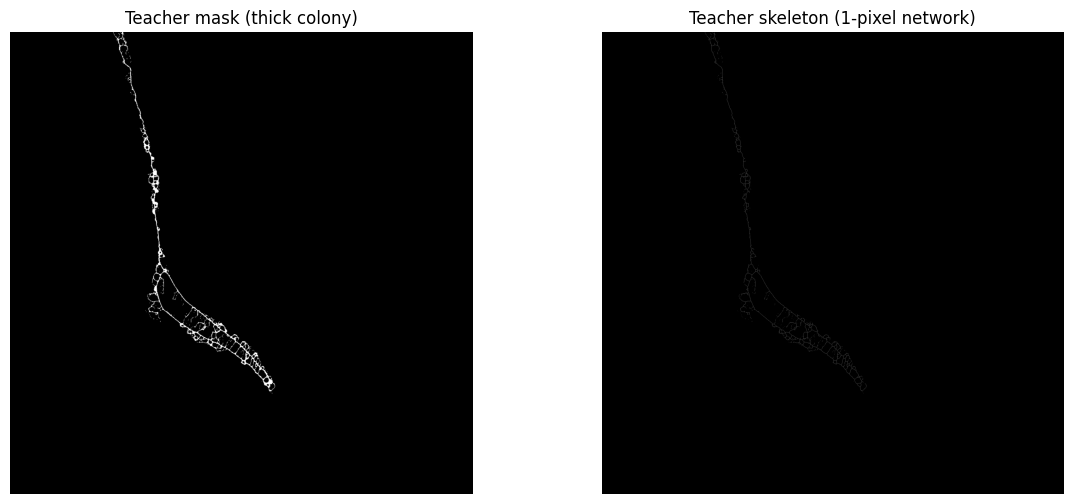

Skeleton shape: (5001, 5001)
Skeleton density (% of pixels): 0.06526189263247131


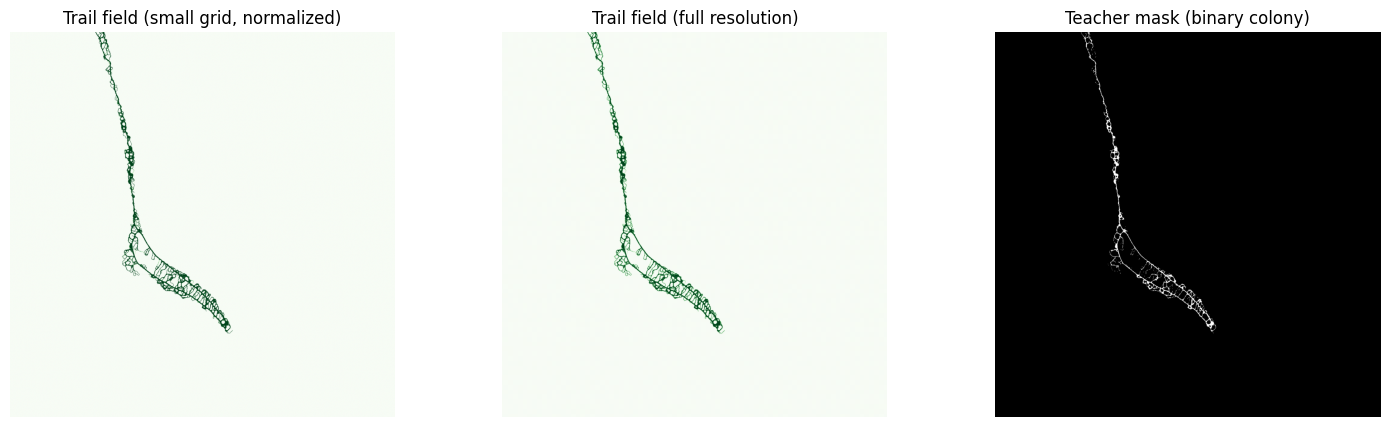

Teacher mask shape: (5001, 5001) dtype: uint8
Colony coverage (% of pixels): 0.5477648721405489


In [ ]:
# 10. Physarum Agent Simulation → Teacher Mask

from skimage.transform import resize
from scipy.ndimage import uniform_filter

# ============= Parameters =============

class PhysarumConfig:
    scale_factor = 4

    n_agents      = 8000      # more agents → more detail
    n_steps       = 10000      # keep as you have now

    step_size     = 1
    sensor_dist   = 4.0
    sensor_angle  = np.deg2rad(35)
    turn_angle    = np.deg2rad(25)

    w_trail       = 0.5
    w_attr        = 4.0       # slightly stronger pull of attractiveness

    deposit       = 1.0
    decay         = 0.05      # more evaporation → only persistent paths survive
    diffuse_kernel = 1        # less blur → sharper line

    mask_threshold = 1      # keep only the “core” of the trail


p = PhysarumConfig()

# ============= Prepare fields (downscaled) =============

H, W = attractiveness_n.shape
Hs = H // p.scale_factor
Ws = W // p.scale_factor

attr_small = resize(
    attractiveness_n,
    (Hs, Ws),
    order=1,
    mode="reflect",
    anti_aliasing=True,
).astype(np.float32)

# Convert to "food" field (higher is more attractive)
food_field = 1.0 - attr_small

trail = np.zeros_like(food_field, dtype=np.float32)

# Map seed position to small grid
seed_y_small = int(seed_y * Hs / H)
seed_x_small = int(seed_x * Ws / W)

print("Simulation grid:", Hs, "x", Ws)
print("Seed on small grid:", seed_x_small, seed_y_small)

# ============= Initialize agents =============

rng = np.random.default_rng(42)

agents_x = rng.normal(seed_x_small, 10.0, size=p.n_agents)
agents_y = rng.normal(seed_y_small, 10.0, size=p.n_agents)
agents_theta = rng.uniform(0, 2*np.pi, size=p.n_agents)

# Clamp initial positions
agents_x = np.clip(agents_x, 0, Ws-1)
agents_y = np.clip(agents_y, 0, Hs-1)

# ============= Simulation loop =============

for step in tqdm(range(p.n_steps), desc="Physarum simulation"):

    # Combined field that agents sense
    field = p.w_trail * trail + p.w_attr * food_field

    # Sensing directions: forward, left, right
    theta = agents_theta

    # Forward
    fx = agents_x + np.cos(theta) * p.sensor_dist
    fy = agents_y + np.sin(theta) * p.sensor_dist

    # Left
    lx = agents_x + np.cos(theta + p.sensor_angle) * p.sensor_dist
    ly = agents_y + np.sin(theta + p.sensor_angle) * p.sensor_dist

    # Right
    rx = agents_x + np.cos(theta - p.sensor_angle) * p.sensor_dist
    ry = agents_y + np.sin(theta - p.sensor_angle) * p.sensor_dist

    # Clamp to grid
    fx_i = np.clip(fx.round().astype(int), 0, Ws-1)
    fy_i = np.clip(fy.round().astype(int), 0, Hs-1)
    lx_i = np.clip(lx.round().astype(int), 0, Ws-1)
    ly_i = np.clip(ly.round().astype(int), 0, Hs-1)
    rx_i = np.clip(rx.round().astype(int), 0, Ws-1)
    ry_i = np.clip(ry.round().astype(int), 0, Hs-1)

    # Sense field values
    Sf = field[fy_i, fx_i]
    Sl = field[ly_i, lx_i]
    Sr = field[ry_i, rx_i]

    # Decide turning
    # Higher field = more attractive
    # If left best → turn left; if right best → turn right; else go straight
    turn_left  = (Sl > Sf) & (Sl > Sr)
    turn_right = (Sr > Sf) & (Sr > Sl)
    straight   = ~(turn_left | turn_right)

    agents_theta = agents_theta + turn_left * p.turn_angle
    agents_theta = agents_theta - turn_right * p.turn_angle
    # small random jitter to avoid locked patterns
    agents_theta = agents_theta + rng.normal(scale=0.02, size=p.n_agents)

    # Move agents
    agents_x += np.cos(agents_theta) * p.step_size
    agents_y += np.sin(agents_theta) * p.step_size

    # Clamp to bounds
    agents_x = np.clip(agents_x, 0, Ws-1)
    agents_y = np.clip(agents_y, 0, Hs-1)

    # Deposit trail
    xi = agents_x.round().astype(int)
    yi = agents_y.round().astype(int)
    trail[yi, xi] += p.deposit

    # Evaporation + diffusion
    if p.decay > 0:
        trail *= (1.0 - p.decay)
    if p.diffuse_kernel > 1:
        trail = uniform_filter(trail, size=p.diffuse_kernel)

# ============= Build teacher mask at full resolution =============

# Normalize trail
trail_small_norm = normalize_channel(trail)

# Upscale to DEM resolution
trail_big = resize(
    trail_small_norm,
    (H, W),
    order=1,
    mode="reflect",
    anti_aliasing=True,
).astype(np.float32)

teacher_mask = (trail_big >= p.mask_threshold).astype(np.uint8)

# 10.5 Skeletonization of the Physarum Teacher

from skimage.morphology import skeletonize

# Convert teacher mask (uint8) to boolean
binary = teacher_mask.astype(bool)

# Get 1-pixel wide skeleton
teacher_skeleton = skeletonize(binary).astype(np.uint8)

# Visualize both
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].imshow(teacher_mask, cmap="gray")
axs[0].set_title("Teacher mask (thick colony)")
axs[0].axis("off")

axs[1].imshow(teacher_skeleton, cmap="gray")
axs[1].set_title("Teacher skeleton (1-pixel network)")
axs[1].axis("off")

plt.show()

print("Skeleton shape:", teacher_skeleton.shape)
print("Skeleton density (% of pixels):", 100 * teacher_skeleton.mean())

# Visualize
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].imshow(trail_small_norm, cmap="Greens")
axs[0].set_title("Trail field (small grid, normalized)")
axs[0].axis("off")

axs[1].imshow(trail_big, cmap="Greens")
axs[1].set_title("Trail field (full resolution)")
axs[1].axis("off")

axs[2].imshow(teacher_mask, cmap="gray")
axs[2].set_title("Teacher mask (binary colony)")
axs[2].axis("off")

plt.show()

print("Teacher mask shape:", teacher_mask.shape, "dtype:", teacher_mask.dtype)
print("Colony coverage (% of pixels):", 100.0 * teacher_mask.mean())


**10.5Debug Plots: Scalar Fields & Early Growth Frames**


---
imshow panels: slope, radiation, attractiveness field, early Physarum trails.


**11.Growth Score + Growth Model (Teacher Mask)**


---


Combine slope, roughness, radiation, distance to POI

Add shortest-walk factor

Generate growth mask (greedy or semi-stochastic)

Base resolution: 5001 x 5001
Feature tensor X shape (C, H, W): (9, 5001, 5001)
Target mask   Y_mask shape: (5001, 5001)
Target skeleton Y_skel shape: (5001, 5001)
NaNs in X: 0   NaNs in Y_mask: 0

Channel order:
  0: dem_n
  1: slope_n
  2: rough_n
  3: radiation_n
  4: poi_dist
  5: poi_dir_x
  6: poi_dir_y
  7: shortest_walk
  8: voronoi_elev_n


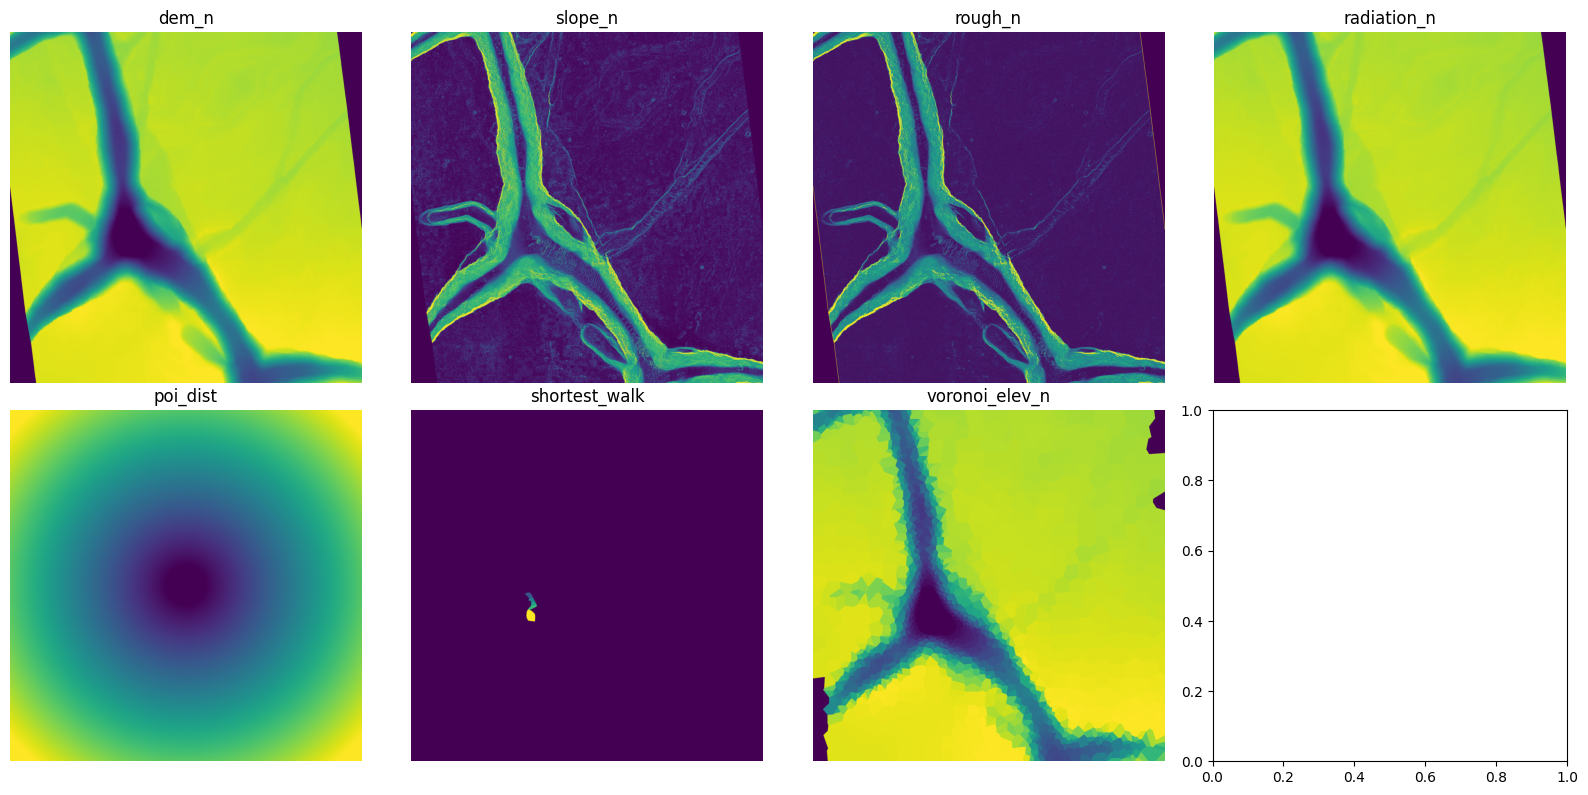

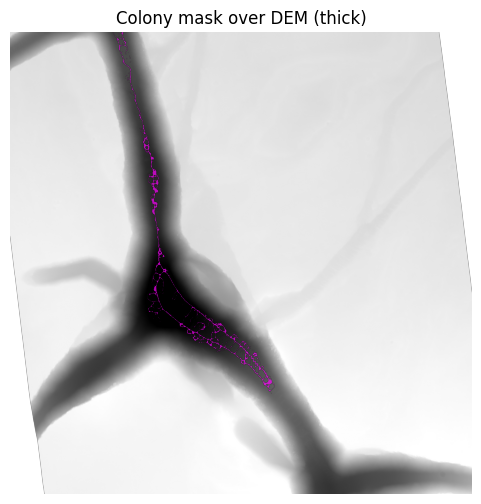

In [ ]:
# 11. Stack Channels for ML

# All feature maps must be float32 and same shape
H, W = dem_n.shape
print("Base resolution:", H, "x", W)

# -----------------------------
# Input feature channels (normalized)
# -----------------------------
feature_channels = [
    ("dem_n",          dem_n.astype(np.float32)),
    ("slope_n",        slope_n.astype(np.float32)),
    ("rough_n",        rough_n.astype(np.float32)),
    ("radiation_n",    radiation_n.astype(np.float32)),
    ("poi_dist",       poi_dist.astype(np.float32)),
    ("poi_dir_x",      poi_dir_x.astype(np.float32)),
    ("poi_dir_y",      poi_dir_y.astype(np.float32)),
    ("shortest_walk",  shortest_walk.astype(np.float32)),
    ("voronoi_elev_n", voronoi_elev_n.astype(np.float32)),
]

# Stack into (C, H, W) array for PyTorch
X_raw = np.stack([ch[1] for ch in feature_channels], axis=0)

# Replace NaNs / infs just in case
X = np.nan_to_num(X_raw, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

# -----------------------------
# Targets
# -----------------------------
# Thick colony mask as main supervision signal
Y_mask = (teacher_mask > 0).astype(np.float32)

# 1-pixel skeleton kept for analysis/post-processing (not used in loss for now)
Y_skel = (teacher_skeleton > 0).astype(np.float32)

print("Feature tensor X shape (C, H, W):", X.shape)
print("Target mask   Y_mask shape:", Y_mask.shape)
print("Target skeleton Y_skel shape:", Y_skel.shape)

print("NaNs in X:", np.isnan(X).sum(), "  NaNs in Y_mask:", np.isnan(Y_mask).sum())

print("\nChannel order:")
for i, (name, _) in enumerate(feature_channels):
    print(f"  {i}: {name}")

# -----------------------------
# Quick visual check: channels + mask
# -----------------------------
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

display_names = ["dem_n", "slope_n", "rough_n", "radiation_n",
                 "poi_dist", "shortest_walk", "voronoi_elev_n"]

for ax, ch_name in zip(axs.ravel(), display_names):
    idx = [i for i, (name, _) in enumerate(feature_channels) if name == ch_name][0]
    ax.imshow(X[idx], cmap="viridis")
    ax.set_title(ch_name)
    ax.axis("off")

plt.tight_layout()
plt.show()

# Overlay of mask on DEM for sanity
plt.figure(figsize=(6, 6))
plt.imshow(dem_n, cmap="gray")
plt.imshow(np.ma.masked_where(Y_mask == 0, Y_mask),
           cmap="spring", alpha=0.7)
plt.title("Colony mask over DEM (thick)")
plt.axis("off")
plt.show()


**12.Stack Channels for ML**


---


Stack:

DEM

slope

roughness

radiation

POI distance

POI direction

Shortest-walk

Voronoi region

Teacher mask (target)

Tiling with size = 256 stride = 128
Total possible tiles: 1444
Selected (non-empty colony mask) tiles: 131
Patch X shape: (131, 9, 256, 256)
Patch Y shape: (131, 256, 256)


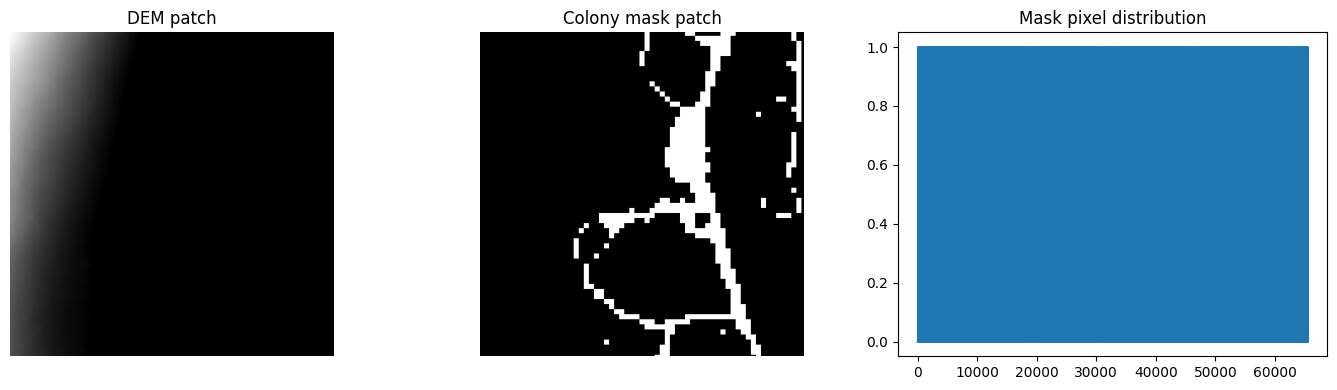

In [ ]:
# 12. Dataset Class + Tiling System (Improved)

import torch
from torch.utils.data import Dataset, DataLoader

tile_size = 256
stride = 128

print("Tiling with size =", tile_size, "stride =", stride)

# ----------------------------
# Create sliding-window patches
# ----------------------------
patches_X = []
patches_Y = []

H, W = Y_mask.shape

for y in range(0, H - tile_size + 1, stride):
    for x in range(0, W - tile_size + 1, stride):

        # Extract tiles
        x_tile = X[:, y:y+tile_size, x:x+tile_size]
        y_tile = Y_mask[y:y+tile_size, x:x+tile_size]

        # Replace NaNs
        x_tile = np.nan_to_num(x_tile, nan=0.0, posinf=0.0, neginf=0.0)
        y_tile = np.nan_to_num(y_tile, nan=0.0)

        # -----------------------------------------
        # NEW: Keep *all* tiles where colony mask > 0
        # -----------------------------------------
        if y_tile.sum() > 0:       # was >= 10 before — too strict!
            patches_X.append(x_tile)
            patches_Y.append(y_tile)

total_tiles = ((H - tile_size)//stride + 1) * ((W - tile_size)//stride + 1)

print("Total possible tiles:", total_tiles)
print("Selected (non-empty colony mask) tiles:", len(patches_X))

patches_X = np.array(patches_X, dtype=np.float32)
patches_Y = np.array(patches_Y, dtype=np.float32)

print("Patch X shape:", patches_X.shape)
print("Patch Y shape:", patches_Y.shape)

# ----------------------------
# Dataset Class
# ----------------------------
class MarsPatchDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx])
        y = torch.from_numpy(self.Y[idx]).unsqueeze(0)  # (1, H, W)
        return x, y

dataset = MarsPatchDataset(patches_X, patches_Y)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# ----------------------------
# Visual check
# ----------------------------
xb, yb = next(iter(dataloader))

fig, axs = plt.subplots(1, 3, figsize=(14, 4))

# DEM = first channel
dem_idx = [i for i, (name, _) in enumerate(feature_channels) if name == "dem_n"][0]

axs[0].imshow(xb[0, dem_idx], cmap="gray")
axs[0].set_title("DEM patch")
axs[0].axis("off")

axs[1].imshow(yb[0, 0], cmap="gray")
axs[1].set_title("Colony mask patch")
axs[1].axis("off")

# Check that y has positive pixels
axs[2].plot(yb[0, 0].numpy().flatten())
axs[2].set_title("Mask pixel distribution")

plt.tight_layout()
plt.show()


**13.Dataset Class + Tiling System**


---


Create ML dataset from stacked channels

DataLoader

Using device: cuda
Model parameters: 13.394817 M
Epoch 1/5 - mean loss: 0.5405
Epoch 2/5 - mean loss: 0.4190
Epoch 3/5 - mean loss: 0.3728
Epoch 4/5 - mean loss: 0.3512
Epoch 5/5 - mean loss: 0.3282
Training finished.


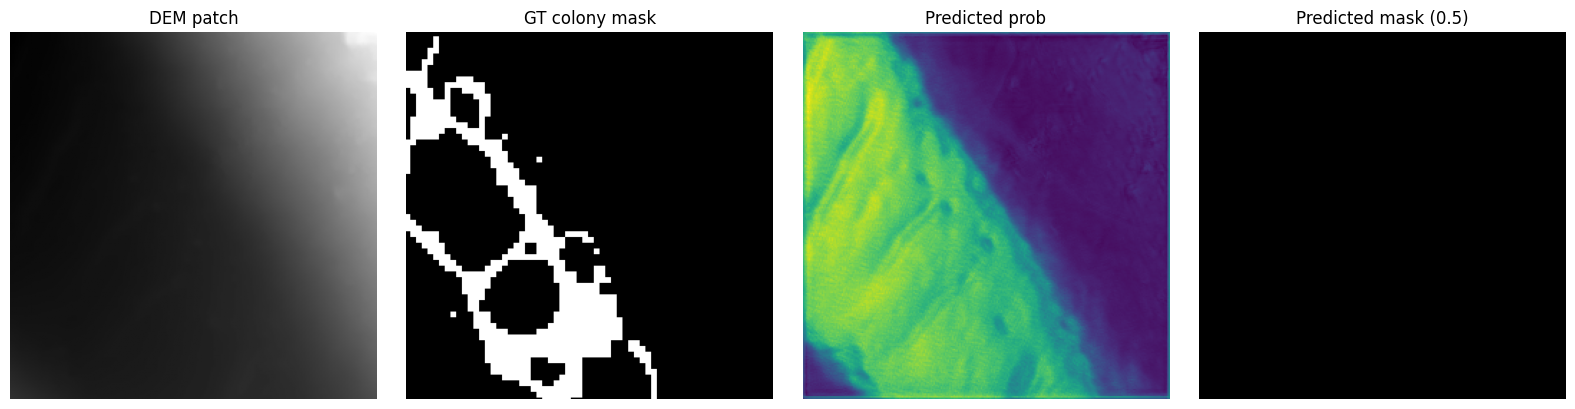

CUDA available: True


In [ ]:
# 13. U-Net Model + Training Loop

import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# U-Net building blocks
# -----------------------------

class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x


class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_ch, out_ch)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        # x1 = upsampled, x2 = skip connection
        x1 = self.up(x1)
        # Pad if needed (should not be necessary with 256x256 tiles, but safe)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes=1, bilinear=True):
        super().__init__()
        self.in_conv = DoubleConv(n_channels, 64)
        self.down1   = Down(64, 128)
        self.down2   = Down(128, 256)
        self.down3   = Down(256, 512)
        self.down4   = Down(512, 512)
        self.up1     = Up(512 + 512, 256, bilinear)
        self.up2     = Up(256 + 256, 128, bilinear)
        self.up3     = Up(128 + 128, 64,  bilinear)
        self.up4     = Up(64 + 64,   64,  bilinear)
        self.out_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)
        logits = self.out_conv(x)
        return logits


# -----------------------------
# Instantiate model, loss, optimizer
# -----------------------------

in_channels = X.shape[0]   # 9 feature channels
model = UNet(n_channels=in_channels, n_classes=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

NUM_EPOCHS = 5   # start small for testing; you can later increase

print("Using device:", device)
print("Model parameters:", sum(p.numel() for p in model.parameters()) / 1e6, "M")


# ---------------------------
# Training loop (fixed)
# ---------------------------
NUM_EPOCHS = 5  # or whatever you want

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    epoch_loss = 0.0

    for xb, yb in dataloader:
        xb = xb.to(device)      # (B, C, H, W)
        yb = yb.to(device)      # (B, 1, H, W)

        optimizer.zero_grad()

        logits = model(xb)      # (B, 1, H, W)  <-- NO squeeze here

        loss = criterion(logits, yb)
        loss = torch.nan_to_num(loss, nan=0.0, posinf=10.0, neginf=0.0)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * xb.size(0)

    epoch_loss /= len(dataset)
    print(f"Epoch {epoch}/{NUM_EPOCHS} - mean loss: {epoch_loss:.4f}")

print("Training finished.")


# -----------------------------
# Quick qualitative check on one batch
# -----------------------------

# ===== Post-training visualization (fixed) =====

model.eval()

xb, yb = next(iter(dataloader))

xb = xb.to(device)
yb = yb.to(device)

with torch.no_grad():
    logits = model(xb)                 # (B, 1, H, W)
    probs  = torch.sigmoid(logits)     # (B, 1, H, W)

# Move to CPU
xb_cpu    = xb.cpu().numpy()
yb_cpu    = yb.cpu().numpy()
probs_cpu = probs.cpu().numpy()

# Use the first patch in the batch
b = 0

# DEM channel index
dem_idx = [i for i, (name, _) in enumerate(feature_channels) if name == "dem_n"][0]

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# DEM
axs[0].imshow(xb_cpu[b, dem_idx], cmap="gray")
axs[0].set_title("DEM patch")
axs[0].axis("off")

# Ground-truth colony mask (CHANGED)
axs[1].imshow(yb_cpu[b, 0], cmap="gray")
axs[1].set_title("GT colony mask")
axs[1].axis("off")

# Predicted probability (CHANGED)
axs[2].imshow(probs_cpu[b, 0], cmap="viridis")
axs[2].set_title("Predicted prob")
axs[2].axis("off")

# Predicted binary mask (CHANGED)
axs[3].imshow(probs_cpu[b, 0] > 0.5, cmap="gray")
axs[3].set_title("Predicted mask (0.5)")
axs[3].axis("off")

plt.tight_layout()
plt.show()
import torch
print("CUDA available:", torch.cuda.is_available())



**14.U-Net Model Definition**


---


Clean U-Net architecture

In [ ]:
# 14. U-Net Model Definition
# Clean U-Net architecture

import torch
import torch.nn as nn

# --------- U-Net blocks ---------

class DoubleConv(nn.Module):
    """(Conv → BN → ReLU) × 2"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        return self.net(x)


class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_ch, out_ch)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        # x1: from decoder, x2: skip connection from encoder
        x1 = self.up(x1)

        # Pad if needed (safety for odd sizes)
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = nn.functional.pad(
            x1,
            [diffX // 2, diffX - diffX // 2,
             diffY // 2, diffY - diffY // 2]
        )

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes=1, bilinear=True):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Encoder
        self.inc   = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)

        # Bottleneck
        self.down4 = Down(256, 512)

        # Decoder
        factor = 2 if bilinear else 1
        self.up1 = Up(512 + 256, 256 // factor, bilinear)
        self.up2 = Up(256 // factor + 128, 128 // factor, bilinear)
        self.up3 = Up(128 // factor + 64, 64 // factor, bilinear)
        self.up4 = Up(64 // factor + 32, 32, bilinear)

        self.outc = OutConv(32, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)

        logits = self.outc(x)          # (B, 1, H, W)
        return logits


# --------- Instantiate model, loss, optimizer ---------

in_channels = X.shape[0]   # should be 9 feature channels
print("Number of input channels:", in_channels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = UNet(in_channels, n_classes=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("Using device:", device)
print("Model parameters:", sum(p.numel() for p in model.parameters()) / 1e6, "M")


Number of input channels: 9
Using device: cuda
Model parameters: 6.007233 M


**15.Training Loop**


---


BCE loss

Adam optimizer

Epoch loop with progress bar

Using device: cuda
Model parameters: 6.007233 M
Epoch 1/5 - mean loss: 0.5556
Epoch 2/5 - mean loss: 0.4666
Epoch 3/5 - mean loss: 0.4232
Epoch 4/5 - mean loss: 0.3986
Epoch 5/5 - mean loss: 0.3763
Training finished.


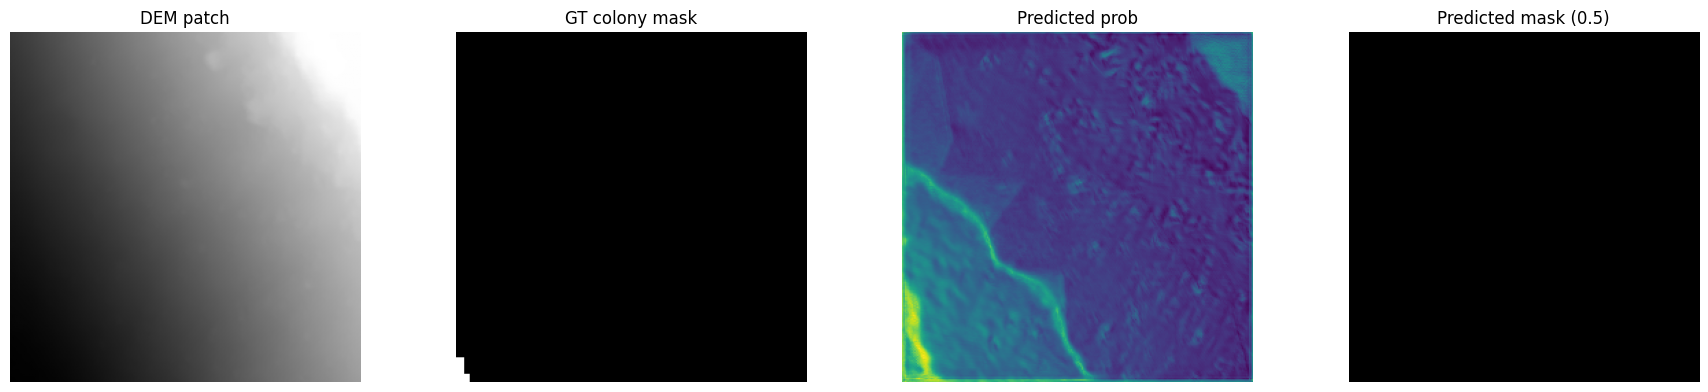

CUDA available: True


In [ ]:
# -------------------------------------------
# 15. Training Loop (clean + GPU-safe)
# -------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

in_channels = X.shape[0]   # Should be 9
model = UNet(n_channels=in_channels, n_classes=1).to(device)

print("Model parameters:", sum(p.numel() for p in model.parameters()) / 1e6, "M")

criterion = nn.BCEWithLogitsLoss()        # good for binary masks
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

NUM_EPOCHS = 5  # puedes subir a 20–40 después

# -------------------------------------------
# Training loop
# -------------------------------------------
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    epoch_loss = 0.0

    for xb, yb in dataloader:
        xb = xb.to(device)            # (B, 9, 256, 256)
        yb = yb.to(device)            # (B, 1, 256, 256)

        optimizer.zero_grad()

        logits = model(xb)            # (B, 1, 256, 256)
        loss = criterion(logits, yb)  # BCE loss

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * xb.size(0)

    epoch_loss /= len(dataset)
    print(f"Epoch {epoch}/{NUM_EPOCHS} - mean loss: {epoch_loss:.4f}")

print("Training finished.")


# -------------------------------------------
# Quick qualitative check on one batch
# -------------------------------------------
model.eval()

with torch.no_grad():
    xb, yb = next(iter(dataloader))
    xb = xb.to(device)
    yb = yb.to(device)

    logits = model(xb)                     # (B,1,H,W)
    probs = torch.sigmoid(logits)         # convert to probability
    preds = (probs > 0.5).float()         # thresholded mask

# Move to CPU for visualization
xb_cpu = xb.cpu()
yb_cpu = yb.cpu()
probs_cpu = probs.cpu()
preds_cpu = preds.cpu()

# Plot first patch in batch
b = 0

fig, axs = plt.subplots(1, 4, figsize=(18, 4))

# DEM patch
dem_idx = [i for i, (name, _) in enumerate(feature_channels) if name == "dem_n"][0]
axs[0].imshow(xb_cpu[b, dem_idx], cmap="gray")
axs[0].set_title("DEM patch")
axs[0].axis("off")

# Ground truth colony mask
axs[1].imshow(yb_cpu[b, 0], cmap="gray")
axs[1].set_title("GT colony mask")
axs[1].axis("off")

# Probabilities
axs[2].imshow(probs_cpu[b, 0], cmap="viridis")
axs[2].set_title("Predicted prob")
axs[2].axis("off")

# Thresholded mask
axs[3].imshow(preds_cpu[b, 0], cmap="gray")
axs[3].set_title("Predicted mask (0.5)")
axs[3].axis("off")

plt.tight_layout()
plt.show()

print("CUDA available:", torch.cuda.is_available())


**16.Validation & Visualization**


---


Overlay predictions on DEM

Compare teacher mask vs ML prediction

**17.Save Outputs**

---


Save trained model

Save predicted masks

Save visualization PNGs
